In [2]:
import scipy.io
import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns

import mat73

import utils as util
import plotting as putil
import importlib

In [3]:
%matplotlib notebook

putil.set_sns_style(style='dark', min_fontsize=12)

In [355]:
# rootdir = '/Volumes/Julie'
rootdir = '/mnt/giacomo'
viddir = os.path.join(rootdir, 'projector_data')
#rootdir = '/mnt/minerva/courtship-videos'
# rootdir = '/mnt/sda/Videos'
acq='20240202-1125_fly4_Dmel_sP1-ChR_3do_sh'
acq = '20240205-1025_fly1_Dmel_sP1-ChR_3do_sh'

In [356]:
acq_dir = os.path.join(viddir, acq)
os.path.exists(viddir)

True

In [379]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [380]:
fps = 60 #frames/sec
calib_, trk_, feat_ = util.load_flytracker_data(acq_dir, fps=fps)


No calibration!


In [381]:
trk_['pos_x'] =  trk_['pos_x'].interpolate()
trk_['pos_y'] =  trk_['pos_y'].interpolate()

<IPython.core.display.Javascript object>


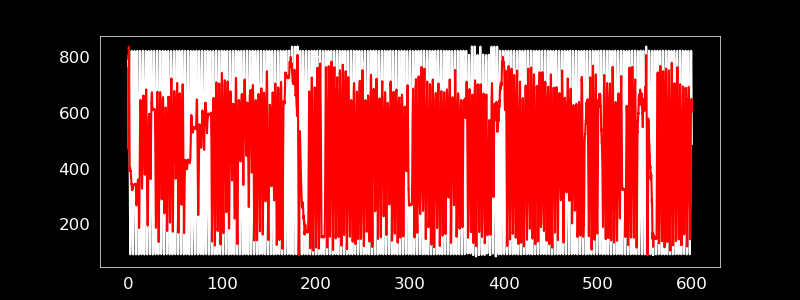

In [382]:
fig, ax = pl.subplots(figsize=(8,3))

ax.plot(trk_[trk_['id']==1]['sec'], trk_[trk_['id']==1]['pos_x'], 'w')
ax.plot(trk_[trk_['id']==0]['sec'], trk_[trk_['id']==0]['pos_x'], 'r')

In [383]:
from numpy.fft import fft, ifft, fftfreq

In [384]:
def get_fft(x, t): # sr=60):

    # sampling interval
    ts = np.mean(np.diff(t)) #1.0/sr
    npnts =  len(t)
    
    X = fft(x)
#     N = len(X)
#     n = np.arange(N)
#     T = N/sr
#     freq = n/T  # freq mirrorin above nyquist
    freq = fftfreq(npnts, ts)
    
    return X, freq #X, freq

In [385]:
# dot info
x = trk_[trk_['id']==1]['pos_x'].values - trk_[trk_['id']==1]['pos_x'].mean()
t =  trk_[trk_['id']==1]['sec'] #np.arange(0,1,ts)
# dot FFT
X, freq = get_fft(x, t)
# fly info
x0 = trk_[trk_['id']==0]['pos_x'] - trk_[trk_['id']==0]['pos_x'].mean()
t0 =  trk_[trk_['id']==0]['sec'] 
# fly FFT
X0, freq0 = get_fft(x0, t0)
# convert to amp -- returns actual amplitude values of the sine and cosine functions
pwr = 2*np.abs(X)/len(t)   
pwr0 = 2*np.abs(X0)/len(t)   
target_freq = 1/3.

<IPython.core.display.Javascript object>


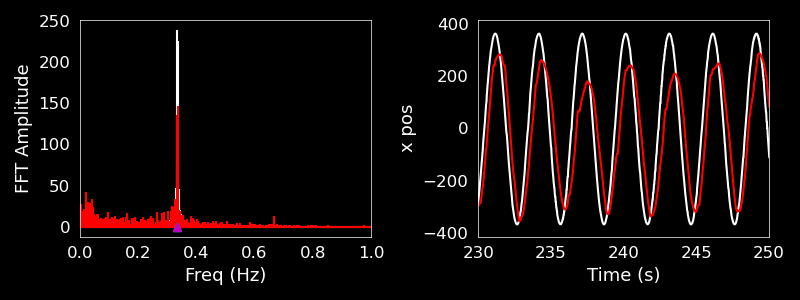

<ipython-input-386-6d47abbde525>:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(freq, pwr, 'w', markerfmt=" ", basefmt="-w")
<ipython-input-386-6d47abbde525>:5: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(freq0, pwr0, 'r', markerfmt=" ", basefmt="-r")
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [386]:
# plot
fig, axn = pl.subplots(1, 2, figsize = (8, 3))
ax=axn[0]
ax.stem(freq, pwr, 'w', markerfmt=" ", basefmt="-w")
ax.stem(freq0, pwr0, 'r', markerfmt=" ", basefmt="-r")
# label
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('FFT Amplitude') #|X(freq)|')
ax.set_xlim(0, 1)

# show max
target_ix = np.argmin(abs(freq-target_freq))
max_ix = np.argmax(X0) 
ax.plot(freq[target_ix], 0, 'c^') 
ax.plot(freq[max_ix], 0, 'm^') 

ax=axn[1]
ax.plot(t, ifft(X), 'w')
ax.plot(t, ifft(X0), 'r')
ax.set_xlim([230, 250]) # manually selected to zoom in
ax.set_xlabel('Time (s)')
ax.set_ylabel('x pos')
pl.tight_layout()
# plt.show()

In [387]:
def calculate_angular_velocity(vals):
    th1 = vals[1:] # diff() * fps
    th2 = vals[:-1]
    th_diff = ((th1 + np.pi/2 - th2) % np.pi) - np.pi/2 # -90 to 90 deg
    #print(max(th_diff), min(th_diff), len(th_diff))
    ang_vel = np.hstack([[th_diff[0]], th_diff])
    
    return ang_vel

In [441]:
fly_id = 0

dot_id = [i for i in trk_['id'].unique() if i != fly_id][0]

flydf = trk_[trk_['id']==fly_id].copy().reset_index(drop=True)
dotdf = trk_[trk_['id']==dot_id].copy().reset_index(drop=True)

In [442]:
ang_vel = feat_[feat_['id']==fly_id]['ang_vel'].values #calculate_angular_velocity(trk_[trk_['id']==fly_id]['ori'].values)
fwd_vel = feat_[feat_['id']==fly_id]['vel'].values
print(min(fwd_vel), max(fwd_vel))

0.0 262.38919403413234


<IPython.core.display.Javascript object>


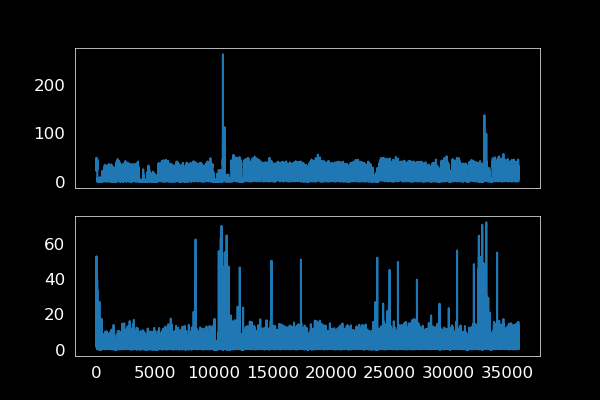

In [439]:
fig, axn = pl.subplots(2, 1, sharex=True)
ax=axn[0]
ax.plot(fwd_vel)

ax=axn[1]
ax.plot(np.abs(ang_vel))

In [399]:
import cv2

In [400]:
movie_fmt = 'avi'
video_fpath = glob.glob(os.path.join(viddir, acq, '*.{}'.format(movie_fmt)))[0] #'{}.{}'.format(fbase, movie_fmt) #esults_fpath.replace('%s_el.h5' % scorer, '.mp4')
assert os.path.exists(video_fpath), "Could not find corresponding video: {}".format(video_fpath)
cap = cv2.VideoCapture(video_fpath)
# N frames should equal size of DCL df
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

frame_width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width`
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`
print(frame_width, frame_height) # array columns x array rows

944.0 952.0


In [433]:
trk_.columns

Index(['pos_x', 'pos_y', 'ori', 'major_axis_len', 'minor_axis_len',
       'body_area', 'fg_area', 'img_contrast', 'min_fg_dist', 'wing_l_x',
       'wing_l_y', 'wing_r_x', 'wing_r_y', 'wing_l_ang', 'wing_l_len',
       'wing_r_ang', 'wing_r_len', 'leg_1_x', 'leg_1_y', 'leg_2_x', 'leg_2_y',
       'leg_3_x', 'leg_3_y', 'leg_4_x', 'leg_4_y', 'leg_5_x', 'leg_5_y',
       'leg_6_x', 'leg_6_y', 'leg_1_ang', 'leg_2_ang', 'leg_3_ang',
       'leg_4_ang', 'leg_5_ang', 'leg_6_ang', 'id', 'fpath', 'frame', 'sec'],
      dtype='object')

In [437]:
feat_.columns

Index(['vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length',
       'axis_ratio', 'fg_body_ratio', 'contrast', 'dist_to_wall',
       'dist_to_other', 'angle_between', 'facing_angle', 'leg_dist', 'id',
       'fpath', 'frame', 'sec'],
      dtype='object')

<IPython.core.display.Javascript object>


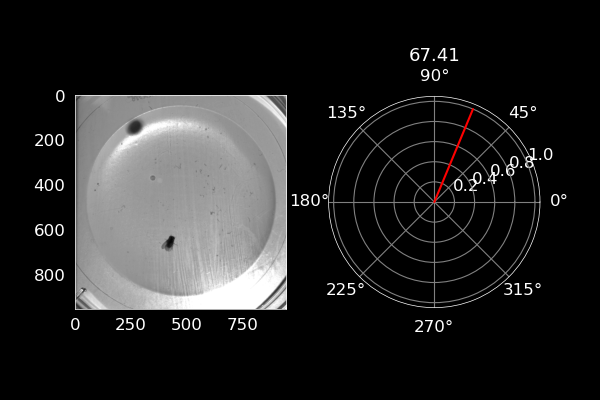

<IPython.core.display.Javascript object>


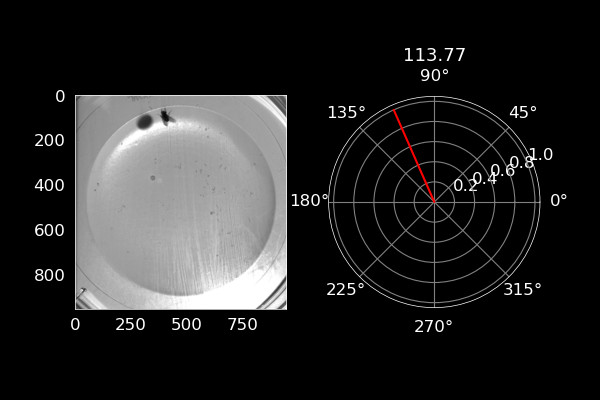

Text(0.5, 1.0, '113.77')

In [447]:
ix =3695
cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)

fig = pl.figure()
ax = fig.add_subplot(121) # axn = pl.subplots(1, 2)
ax.imshow(im, cmap='gray')

ax = fig.add_subplot(122, projection='polar') # axn = pl.subplots(1, 2)
ax.plot([0, flydf['ori'].iloc[ix]], [0, 1], 'r') # when plotting heading, 0 is "East" then it matches the ori of body in movie frame
# ax.set_theta_direction(-1)
# ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_title(round(np.rad2deg(flydf['ori'].iloc[ix]), 2))

##
ix = 100
cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)

fig = pl.figure()
ax = fig.add_subplot(121) # axn = pl.subplots(1, 2)
ax.imshow(im, cmap='gray')

ax = fig.add_subplot(122, projection='polar') # axn = pl.subplots(1, 2)
ax.plot([0, flydf['ori'].iloc[ix]], [0, 1], 'r') # when plotting heading, 0 is "East" then it matches the ori of body in movie frame
# ax.set_theta_direction(-1)
# ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_title(round(np.rad2deg(flydf['ori'].iloc[ix]), 2))

In [448]:
# center coords
flydf['ctr_x'] = flydf['pos_x'] - frame_width/2
flydf['ctr_y'] = flydf['pos_y'] - frame_height/2

dotdf['ctr_x'] = dotdf['pos_x'] - frame_width/2
dotdf['ctr_y'] = dotdf['pos_y'] - frame_height/2

<IPython.core.display.Javascript object>


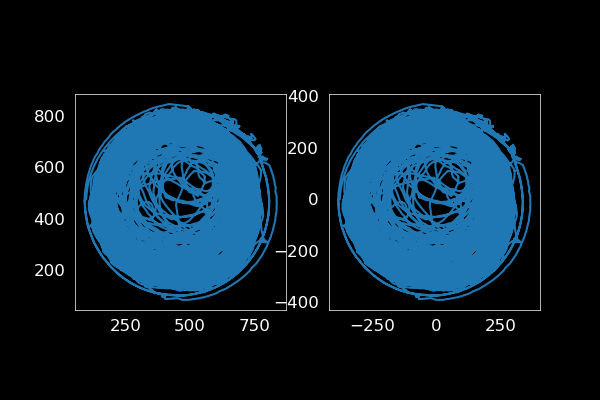

In [449]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
ax.plot(flydf['pos_x'], flydf['pos_y'])
ax.set_aspect(1)

ax=axn[1]
ax.plot(flydf['ctr_x'], flydf['ctr_y'])
ax.set_aspect(1)

In [450]:
# translate all coords by the same amount so that fly in center
flydf['trans_x'] = flydf['ctr_x'] - flydf['ctr_x']
flydf['trans_y'] = flydf['ctr_y'] - flydf['ctr_y'] 

dotdf['trans_x'] = dotdf['ctr_x'] - flydf['ctr_x']
dotdf['trans_y'] = dotdf['ctr_y'] - flydf['ctr_y']

<IPython.core.display.Javascript object>


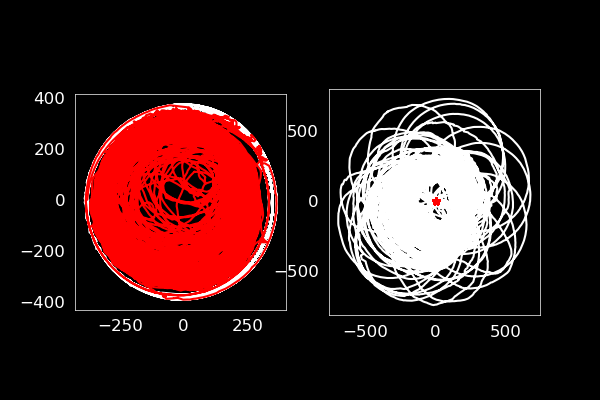

In [451]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
ax.plot(dotdf['ctr_x'], dotdf['ctr_y'], 'w')
ax.plot(flydf['ctr_x'], flydf['ctr_y'], 'r')
ax.set_aspect(1)

ax=axn[1]
ax.plot(dotdf['trans_x'], dotdf['trans_y'], 'w')
ax.plot(flydf['trans_x'], flydf['trans_y'], 'r*')
ax.set_aspect(1)

In [452]:
# def ang_bw_vectors(x1, y1, x2, y2):
#     return np.arctan2(x1*y2 - y1*x2, x1*x2 + y1*y2)

def calculate_angular_position(x, y):
    if x>0 and y>0:
        ang = np.arctan(y/x)
    elif x<0:
        ang = np.arctan(y/x) + np.pi
    elif x>0 and y<0:
        ang = np.arctan(y/x) + 2*np.pi
    return ang
    
def ang_between(v, w): 
    return np.arccos(v.dot(w)/(norm(v)*norm(w)))

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

# convert coordinates so that male facing 0 (east, on default plotting)

In [453]:

ori_vals = trk_[trk_['id']==fly_id]['ori'].values # -pi to pi
ori = -1*ori_vals + np.deg2rad(0) # ori - ori is 0 heading 
print(min(ori_vals), max(ori_vals))

rot_coords = []
for ti, theta in enumerate(ori):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) # get rotation matrix to rotate coords by same amt as M's heading
    new_ = dotdf[['trans_x', 'trans_y']].iloc[ti].dot(R)
    rot_coords.append(new_)
    
rotdf = pd.DataFrame(data = rot_coords, columns = ['rot_x', 'rot_y'])

-3.1415621750707805 3.141592653589793


In [454]:
polar_coords = cart2pol(rotdf['rot_x'], rotdf['rot_y'])
rotdf['rho'] = polar_coords[0]
rotdf['phi'] = polar_coords[1]

#### check transformations

<IPython.core.display.Javascript object>


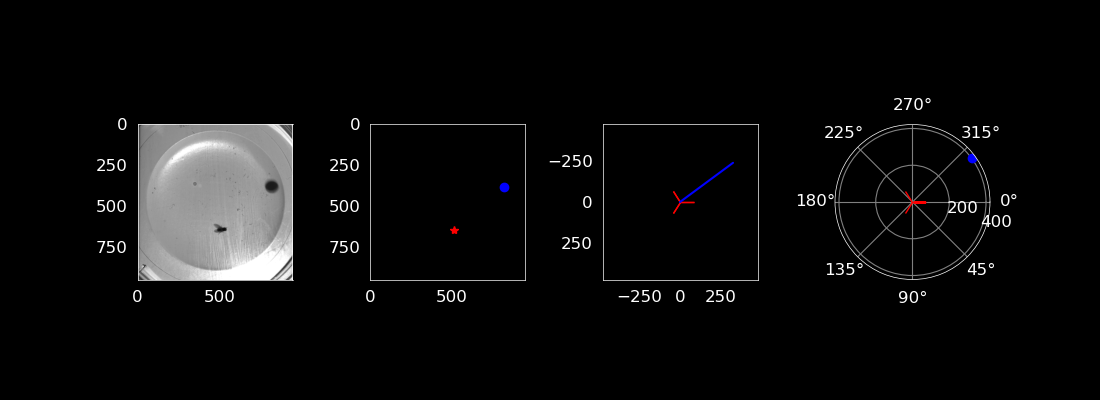

In [455]:
ix = 4000 #5000 #2500 #590
cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)

fig = pl.figure(figsize=(11,4))
ax = fig.add_subplot(141) # axn = pl.subplots(1, 2)
ax.imshow(im, cmap='gray')

ax = fig.add_subplot(142) 
ax.plot(flydf['pos_x'].iloc[ix], flydf['pos_y'].iloc[ix], 'r*')
ax.plot(dotdf['pos_x'].iloc[ix], dotdf['pos_y'].iloc[ix], 'bo')
ax.set_aspect(1)
ax.set_xlim(0, frame_width)
ax.set_ylim(0, frame_height)
ax.invert_yaxis()

ax = fig.add_subplot(143) #, projection='polar') # axn = pl.subplots(1, 2)
ax.plot([0, flydf['trans_x'].iloc[ix]], [0, flydf['trans_y'].iloc[ix]], 'r', marker='4', markersize=20)
ax.plot([0, rotdf['rot_x'].iloc[ix]], [0, rotdf['rot_y'].iloc[ix]], 'b')
ax.set_aspect(1)
ax.set_xlim(0-frame_width/2, frame_width/2)
ax.set_ylim(0-frame_height/2, frame_height/2)
ax.invert_yaxis()

ax = fig.add_subplot(144, projection='polar') # axn = pl.subplots(1, 2)
ax.plot(rotdf['phi'].iloc[ix], rotdf['rho'].iloc[ix], 'bo') # x=theta, y=radius
ax.plot(0, 0, 'r', marker='4', markersize=20)
ax.set_theta_direction(-1)

pl.subplots_adjust(wspace=0.5)

<IPython.core.display.Javascript object>


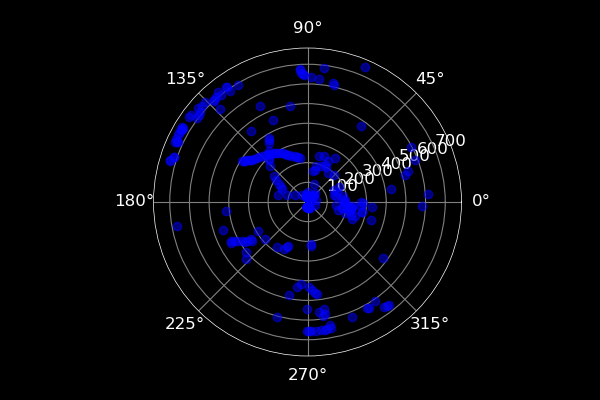

In [484]:
wing_thr = np.deg2rad(60)

fig, ax = pl.subplots(subplot_kw={'projection': 'polar'})

singdf = flydf[(flydf['wing_l_ang']>wing_thr) | (flydf['wing_r_ang']>wing_thr)]
ax.plot(rotdf.loc[singdf.index]['phi'], rotdf.loc[singdf.index]['rho'], 'bo', alpha=0.5,
       ) # x=theta, y=radius

<IPython.core.display.Javascript object>


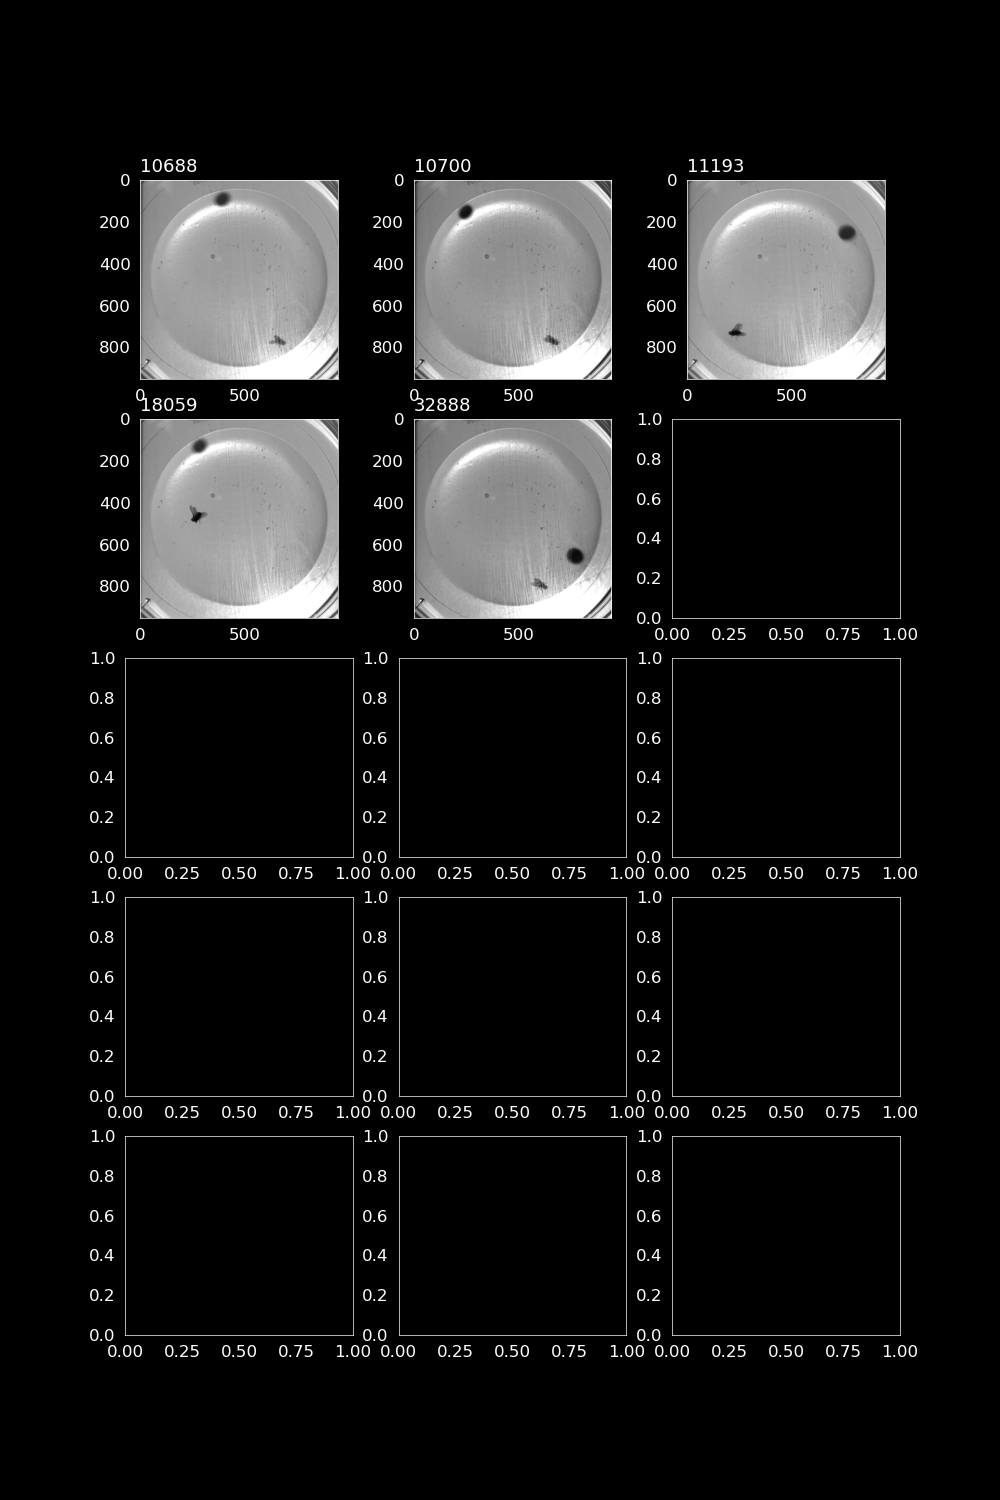

In [486]:
testdf = rotdf.loc[singdf.index].copy()
singing_behind_ixs = testdf[(testdf['phi']>np.deg2rad(135)) & (testdf['phi']<=np.deg2rad(225))].index.tolist()

nr=5; nc=3;
fig, axn = pl.subplots(nr, nc, figsize=(10,15))

for i, ix in enumerate(singing_behind_ixs[0::10]):
    cap.set(1, ix)
    ret, im = cap.read()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)
    ax=axn.flat[i]
    ax.set_title(ix, loc='left')
    ax.imshow(im, cmap='gray')

1        1.701927
2        1.638911
3        1.654428
4        1.644943
5        1.579607
           ...   
34684   -0.115788
34686   -0.145892
34882   -0.361053
34883   -0.380570
35936   -0.144375
Name: phi, Length: 771, dtype: float64